## Name Analysis and forecasting

Exploration of the United States Social Security Administration babynames dataset made available via R package [babynames](http://hadley.github.io/babynames/).

* Plotting names
* Using [Prophet](https://facebook.github.io/prophet/) to forecast if popularity will continue to rise or fall

As the babynames package is in R, and I generally prefer Python, I've used the [rpy2](https://rpy2.bitbucket.io) library to pull in the appropriate portions of babynames

### Table of Contents:
* [Load Baby Names Data](#load_data)
* [Prediction with Prophet](#prophet)
* [Prediction with ARIMA](#arima)
* [Combine names based on pronounciation](#sound_analysis)
* [Name popularity](#popularity)
* [Gender overlap in naming](#gender)

### To Do:

* Compare ARIMA to Prophet for forecast - As Prophet seems to be focused on more frequent data, I'm not convinced it works well with low resolution/infrequent data such as this yearly name data. Of course, I may just not understand how to properly specify parameters to get it to work right. Some URLs with more information regarding ARIMA in python:
  * https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
  * https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851
* Currently just looking at data since 1990. Would including more historical data improve forecast?

In [70]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# enable automatic conversion between R dataframes and Pandas Dataframes
pandas2ri.activate()

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

import matplotlib.pyplot as plt

import os
import pickle
import itertools

from timeit import default_timer as timer

# to prevent some warnings later on
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [71]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [72]:
import seaborn as sns
sns.set()
sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.9',
    'grid.linestyle': u'-',
    'figure.facecolor': 'white', # axes
})
sns.set_context("notebook")

<a id='load_data'></a>

### Loading the name data

Summary of data available in the R package [babynames](http://hadley.github.io/babynames/):

**babynames:** For each year from 1880 to 2017, the number of children of each sex given each name. All names with more than 5 uses are given. (Source: http://www.ssa.gov/oact/babynames/limits.html)

**applicants:** The number of applicants for social security numbers (SSN) for each year for each sex. (Source: http://www.ssa.gov/oact/babynames/numberUSbirths.html)

**lifetables:** Cohort life tables data (Source: http://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html)

It also includes the following data set from the US Census:

**births:** Number of live births by year, up to 2017. (Source: an Excel spreadsheet from the Census that has since been removed from their website and https://www.cdc.gov/nchs/data/nvsr/nvsr66/nvsr66_01.pdf)

In [73]:
bn_filename = 'babynames.pickle'

if os.path.isfile(bn_filename):
    with open(bn_filename, 'rb') as f:
        orig_df = pickle.load(f)
else:
    bn = importr('babynames')
    orig_df = bn.__rdata__.fetch('babynames')['babynames']
    # fix some data types
    orig_df['year'] = orig_df.year.astype('int32')

    with open(bn_filename, 'wb') as f:
        pickle.dump(orig_df, f)

In [74]:
# only want to look at more recent trends
df = orig_df[orig_df.year >= 1990].copy()

In [75]:
tops = df[(df.sex == 'F') & ((df.year >= 2012) & (df.year <= 2017))].sort_values(['year', 'n'], ascending=False).groupby('year', as_index=False).head(20)
print('top femail names 2012 - 2017 by number of times in top 20 per year')
print(tops.groupby('name', as_index=False)['n'].count().sort_values('n', ascending=False))

top femail names 2012 - 2017 by number of times in top 20 per year
         name  n
0     Abigail  6
24     Sophia  6
23      Sofia  6
21     Olivia  6
5         Ava  6
6       Avery  6
7   Charlotte  6
19        Mia  6
9   Elizabeth  6
10       Ella  6
11      Emily  6
12       Emma  6
18    Madison  6
16   Isabella  6
15     Harper  5
13     Evelyn  5
8       Chloe  5
2      Amelia  5
14      Grace  3
25   Victoria  3
1     Addison  2
4      Aubrey  2
22   Scarlett  2
17       Lily  1
20    Natalie  1
3        Aria  1
26       Zoey  1


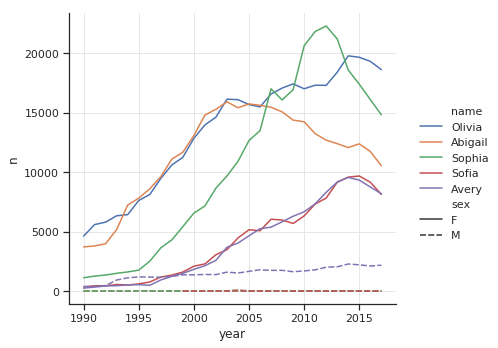

In [76]:
a = df[df.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])]
a_plt = sns.relplot(x='year', y='n', hue='name', style='sex', kind='line', ci=None, data=a)
a_plt.fig.set_size_inches(7.5, 5)

Suppose your selected name is Sophia and soundalikes

<a id='prophet'></a>

### Prophet for prediction of naming trends

Prophet is an R/Python library available from: https://facebook.github.io/prophet/

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [77]:
# select counts without respect to gender
a = df[df.name.isin(['Sophia', 'Sofia'])]
pdf = a.groupby(['year'])['n'].sum().reset_index()
pdf.rename(columns={"year": "ds", "n": "y"}, inplace=True)
pdf['ds'] = pd.to_datetime(pdf['ds'], format='%Y')

/Users/seth/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:n_changepoints greater than number of observations.Using 21.0.
/Users/seth/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


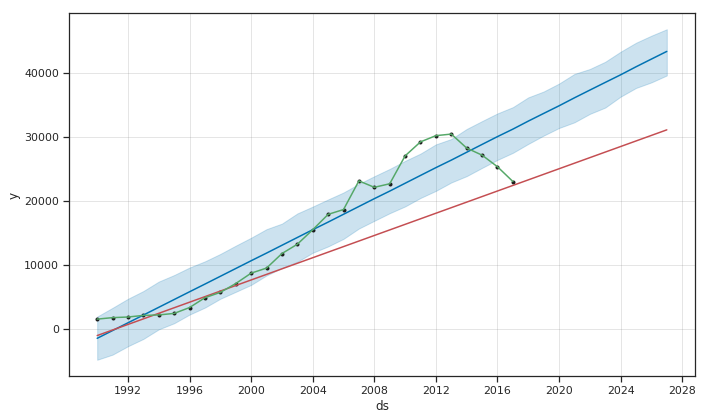

In [78]:
m = Prophet(daily_seasonality=False, weekly_seasonality=False, seasonality_mode='multiplicative')
m.fit(pdf)
# predict 10 years out
future = m.make_future_dataframe(periods=10, freq='Y')
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# show actual data in green
plt.plot(pdf.ds, pdf.y, 'g')

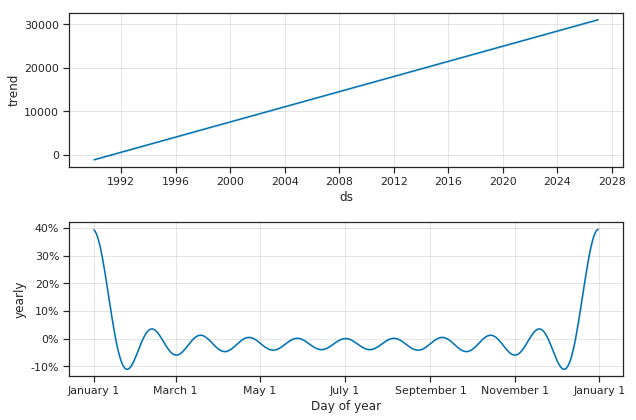

In [79]:
fig = m.plot_components(forecast)

In [80]:
df.head()

,year,sex,name,n,prop
1069606,1990,F,Jessica,46475,0.022627
1069607,1990,F,Ashley,45558,0.022181
1069608,1990,F,Brittany,36538,0.017789
1069609,1990,F,Amanda,34408,0.016752
1069610,1990,F,Samantha,25866,0.012593


In [81]:
df.shape

(855060, 5)

<a id='arima'></a>

### ARIMA for prediction of naming trends

In [82]:
# to do - add this section
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from matplotlib.pylab import rcParams
from pandas.plotting import autocorrelation_plot

In [83]:
rcParams['figure.figsize'] = 15, 12

In [84]:
# select counts without respect to gender
#a = orig_df[(orig_df.name.isin(['Sophia', 'Sofia'])) & (orig_df.year >= 1980)].copy()
a = orig_df[(orig_df.name.isin(['Sophia', 'Sofia']))].copy()
#a = orig_df[(orig_df.name.isin(['Olivia']))].copy()
a['year'] = pd.to_datetime(a['year'], format='%Y')
ts = a.groupby(['year'])['n'].sum()

In [85]:
ts.head()

year
1880-01-01    138
1881-01-01    128
1882-01-01    179
1883-01-01    159
1884-01-01    170
Name: n, dtype: int32

In [86]:
# don't have monthly data, so this doesn't work
#decomposition = seasonal_decompose(ts)

In [87]:
def TestStationaryPlot(ts, plot_label = None):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    if plot_label is not None:
        plt.title('Rolling Mean & Standard Deviation (' + plot_label + ')', fontsize = 25)
    else:
        plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)
    
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

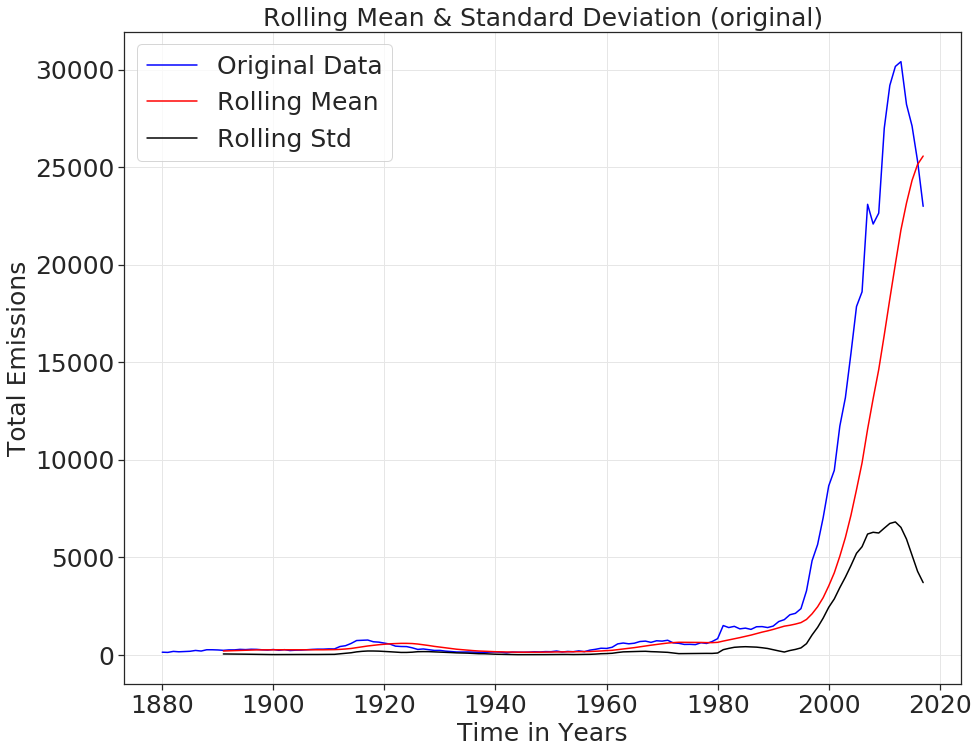

In [88]:
TestStationaryPlot(ts, 'original')

In [89]:
# while most of the data is farily flat for the time period shown (1880 - 1980)
#visual inspection of data doesn't seem to be stationary
TestStationaryAdfuller(ts)

Test Statistic                  -3.684853
p-value                          0.004331
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [90]:
# this is what is looked at for stationarity (is that a word?)
#12*(nobs/100)^{1/4}
nobs = len(ts)
12*(nobs/100)**(1/4)

13.006217658965213

In [91]:
moving_avg = ts.rolling(5).mean()
moving_avg_diff = ts - moving_avg
moving_avg_diff.head(13)

year
1880-01-01     NaN
1881-01-01     NaN
1882-01-01     NaN
1883-01-01     NaN
1884-01-01    15.2
1885-01-01    20.8
1886-01-01    43.8
1887-01-01     9.2
1888-01-01    54.4
1889-01-01    35.8
1890-01-01    12.2
1891-01-01    -8.0
1892-01-01     2.2
Name: n, dtype: float64

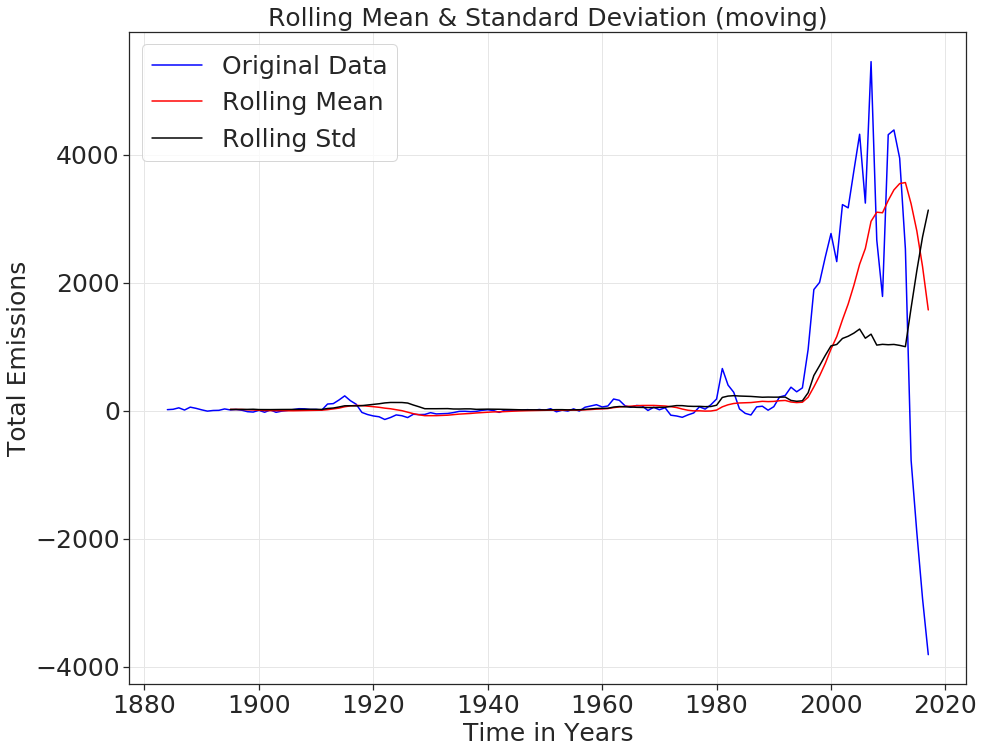

Test Statistic                  -3.833713
p-value                          0.002581
#Lags Used                      12.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [92]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff, 'moving')
TestStationaryAdfuller(moving_avg_diff)

### Autocorrelation Plots

When looking at all data available (1880 to present) it appears that the current value seems to be highly correlated with the previous 14 or so values; closer to the present value is more correlated. Tested a few different names and correlation lag may be as high as 20.

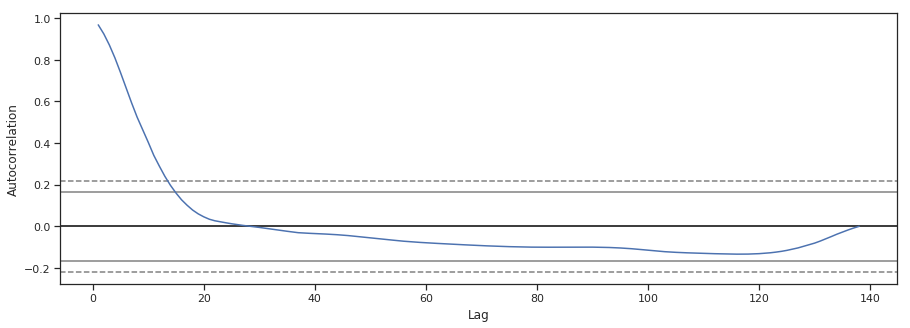

In [93]:
fig, ax = plt.subplots(figsize = (15, 5))
ax = autocorrelation_plot(ts, ax=ax)
#plt.vlines(range(0, 121, 2), -1, 1, linestyle="dashed")

These are autocorrelation plots from Statsmodel

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


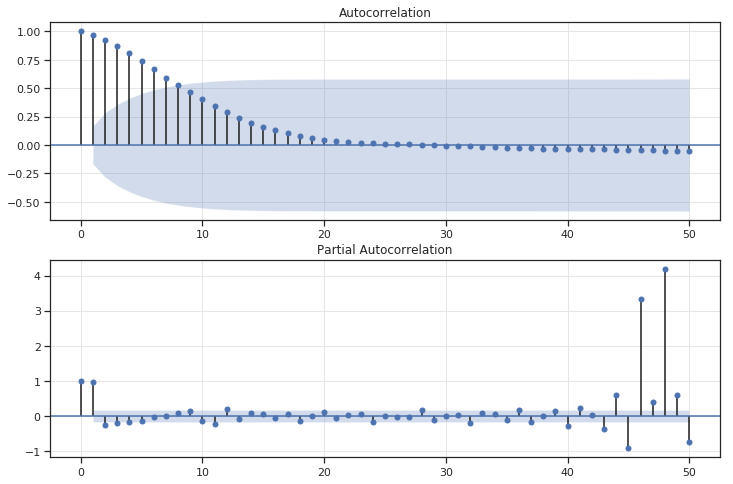

In [94]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=50, ax=ax2)

In [95]:
model = ARIMA(ts, order=(12,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.n   No. Observations:                  137
Model:                ARIMA(12, 1, 0)   Log Likelihood               -1055.454
Method:                       css-mle   S.D. of innovations            538.723
Date:                Tue, 14 May 2019   AIC                           2138.909
Time:                        16:54:40   BIC                           2179.788
Sample:                    01-01-1881   HQIC                          2155.521
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.2137   1.22e-05   5.45e+06      0.000      66.214      66.214
ar.L1.D.n      0.1959        nan        nan        nan         nan         nan
ar.L2.D.n      0.0707    2.5e-07   2.83e+05      0.0

/Users/seth/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/seth/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/seth/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/seth/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


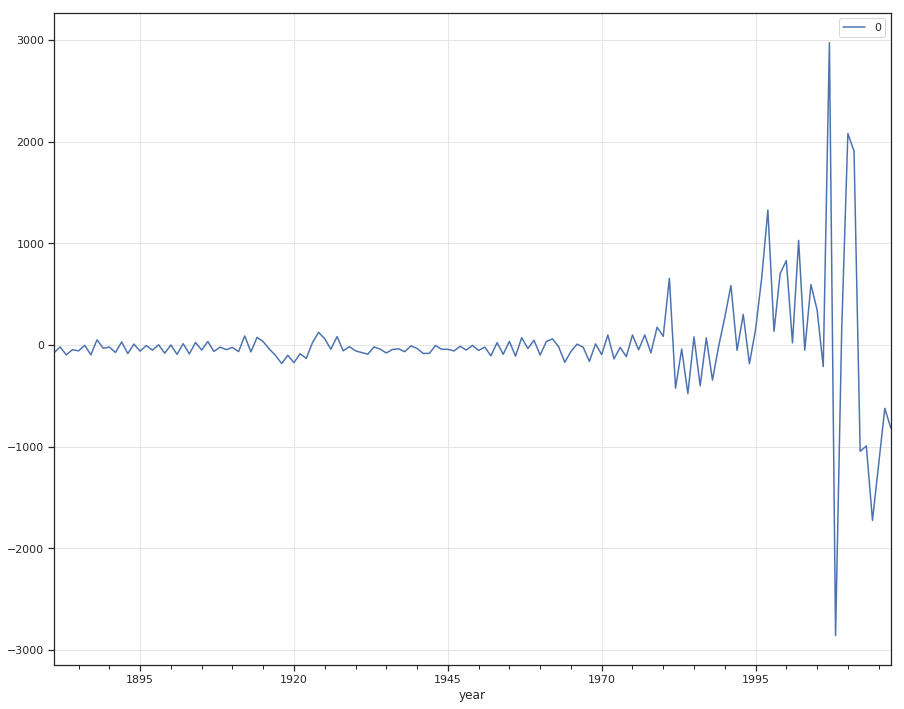

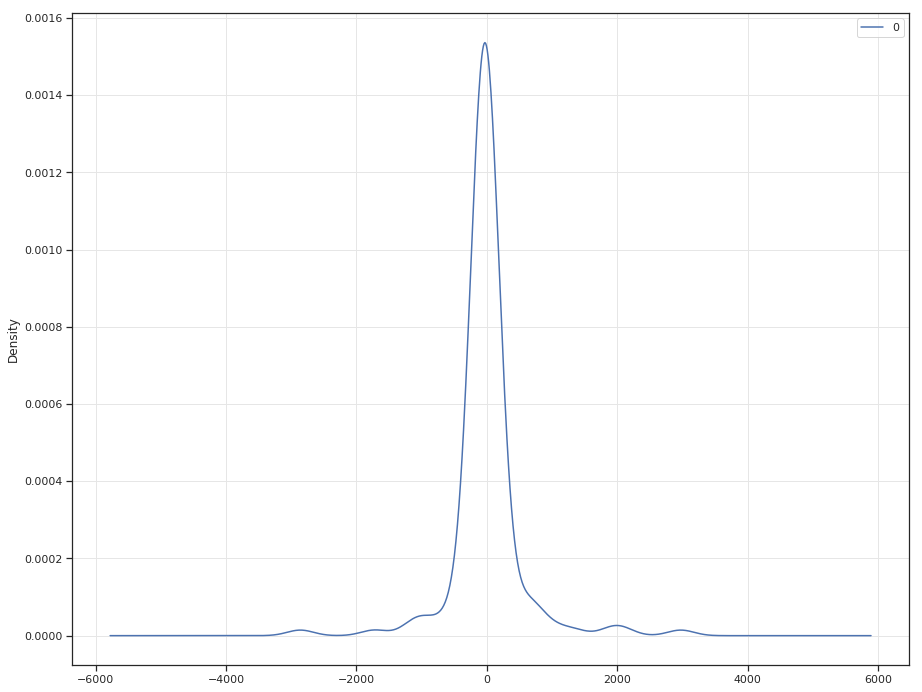

                 0
count   137.000000
mean      3.039001
std     540.652550
min   -2859.365472
25%     -82.285379
50%     -36.912607
75%      34.636848
max    2976.235121


In [96]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [97]:
type(ts)

pandas.core.series.Series

In [98]:
p = d = q = range(0, 3) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

In [99]:
a = orig_df[(orig_df.name.isin(['Sophia', 'Sofia']))].copy()
#a = orig_df[(orig_df.name.isin(['Olivia']))].copy()
#a['year'] = pd.to_datetime(a['year'], format='%Y')
ts = a.groupby(['year'])['n'].sum()

In [127]:
ts.to_frame().asfreq(freq='A', a)

,n
year,


In [123]:
index = pd.date_range('1/1/2000', periods=4, freq='T')
>>> series = pd.Series([0.0, None, 2.0, 3.0], index=index)
>>> df = pd.DataFrame({'s':series})
>>> df

year
1880    138
1881    128
1882    179
1883    159
1884    170
Name: n, dtype: int32

In [122]:
ts.asfreq(freq='Y')

Series([], Freq: A-DEC, Name: n, dtype: int32)

In [100]:
%%time

aic_results = []
for param in pdq:
    try:
        mod = ARIMA(ts,
                    order=param,
                    freq='AS-JAN')
        # some methods fail to converge; increasing max iterations helps
        # some methods have verbose output
        #results = mod.fit(maxiter=200, method='nm')
        # defaults appear to ignore maxiter
        results = mod.fit()
        print('ARIMA:{} - AIC:{}'.format(param, results.aic))
#             if results.mle_retvals is not None and results.mle_retvals['converged'] == False:
#                 print('if block', results.mle_retvals)
#        aic_results.append(results.aic)
    except Exception as e:
        print('exception', e)
        continue
#aic_results.sort()
#print('Best AIC found: ', aic_results[0])

exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates but `freq` argument was provided.
exception Given index could not be coerced to dates bu

In [101]:
results.aic

2150.960532863838

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

<a id='sound_analysis'></a>

### Combine names based on how they sound

As each entry in the babynames dataset is based on spelling, evaluate different sound based algorithms to see how to combine/reduce number of names.

See the [soundconflation](soundconflation.ipynb) notebook for analysis of various phonetic algorithms.

End result is that the Abydos python library has lots of options and I like the Beider & Morse algorithm the best for the purposes of this analysis.

For combination of names based on Beider Morse algorithm, will just look at most recent year.

#### Export names file for testing/evaluation of phonetic algorithms

In [102]:
names = pd.DataFrame()
#apdf = df[['year', 'sex', 'name', 'n', 'prop']][df.year == 1990].head(100).copy()
names['name'] = df.name.unique()
print(names.shape)

with open('ssn_names_only.pickle', 'wb') as f:
    pickle.dump(names, f)

(77092, 1)


Build the data frame of names and beidermorse values

In [103]:
from abydos import phonetic as ap
import multiprocessing
from multiprocessing import Pool
import psutil
from functools import partial

def process_df(function, label, df_in):
    # this is is beidermorse specific; remove this function partial and you can actually parallelize
    # any method that doesn't require additional parameters
    func = partial(function, language_arg = 'english')
    df_in[label] = df_in.name.map(func)
    return df_in

def parallelize(inputdf, function, label):
    num_processes = psutil.cpu_count(logical=False)
    num_partitions = num_processes * 2 #smaller batches to get more frequent status updates (if function provides them)
    func = partial(process_df, function, label)
    with Pool(processes=num_processes) as pool:
        df_split = np.array_split(inputdf, num_partitions)
        df_out = pd.concat(pool.map(func, df_split))
    return df_out

filename = 'names_beidermorse.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        names = pickle.load(f)
else:
    names = parallelize(names, ap.BeiderMorse().encode, 'beidermorse')
    # convert string of names space separated to a set for much faster lookup
    names['bmset'] = names['beidermorse'].str.split().apply(set)

    with open(filename, 'wb') as f:
        pickle.dump(names, f)

names.head()

,name,beidermorse,bmset
0,Jessica,zYsQki zYsiki zYsDki zisQki zisiki zisDki zYsi...,"{zYsDki, zYsQki, zisQka, zYsika, zisDki, zYsQk..."
1,Ashley,izlii izlD izla izli ozlii ozlD ozla ozli azli...,"{ozlii, ozlD, ozli, izlii, izla, azlii, azlD, ..."
2,Brittany,brQtini britini brDtini britoni brQtoni britan...,"{britoni, britini, brQtani, brQtini, britani, ..."
3,Amanda,imindi imndi imindo imndo iminda imnda imondi ...,"{imndo, amindo, omndo, amondo, omondo, omanda,..."
4,Samantha,siminti simnti siminto simnto siminta simnta s...,"{simonta, simnta, somnti, sominta, simanta, sa..."


In [104]:
checklist = names[names.name == 'Sofia'].beidermorse.values[0].split()
def check_fn(input):
    return any(x in input.split() for x in checklist)

names[names.beidermorse.map(check_fn)].head()

,name,beidermorse,bmset
250,Sophia,sofii sofio sofia safii safio safia,"{sofio, safii, safio, sofii, sofia, safia}"
646,Sofia,sofii sofio sofia safii safio safia,"{sofio, safii, safio, sofii, sofia, safia}"
9955,Safia,sifii sifio sifia sofii sofio sofia safii safi...,"{sifia, sifio, sifii, sofio, safii, safio, sof..."
12562,Safaa,sifii sifio sifD sifia sifoi sifoo sifoa sifai...,"{safo, sifio, safa, safoo, sifii, sofoi, sifo,..."
29240,Safiah,sifii sifio sifia sofii sofio sofia safii safi...,"{sifia, sifio, sifii, sofio, safii, safio, sof..."


Create key-value version of Beider Morse mapping - found this improves performance

In [105]:
def f(name, bmset):
    return pd.DataFrame(zip([name] * len(bmset), list(bmset)), columns=('name', 'beidermorse'))
kv_names = pd.concat([f(n,b) for n, b in zip(names['name'], names['bmset'])])

In [106]:
def calc_sound_totals(df_in):
    df_out = df_in.copy()
    df_out['counted'] = False
    df_out['alt_n'] = 0
    df_out['alt_prop'] = 0.0
    df_out['mapped_to'] = ''
    
    filt_names = kv_names.merge(df_out, on='name')[['name', 'beidermorse']]

    # process each row of dataframe
    def create_df_out_n(row):
        # should do no further processing if this row has already been counted
        if (df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'counted'].all() == True):
            return

        # find matching names        
        checklist = filt_names[filt_names.name == row['name']].beidermorse.values
        found = filt_names[filt_names.beidermorse.isin(checklist)]['name'].unique()
        
        # aggregate count, excluding counted names, for all found names into df_out_name
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_n'] = df_out[(df_out.name.isin(found)) & 
                               (df_out.year == row.year) &
                               (df_out.sex == row.sex) &
                               (df_out.counted == False)]['n'].sum()
        
        # set counted flag for found names in group
        # ? how to update just group ?
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'counted'] = True
        df_out.loc[(df_out.name.isin(found)) & (df_out.year == row.year) & (df_out.sex == row.sex), 'mapped_to'] = row['name']

    start = timer()
    gdf = df_out.groupby(['year', 'sex'])
    for name, group in gdf:
        print('processing name:', name)
        g = group.sort_values('n', ascending=False).copy()
        g.apply(create_df_out_n, axis=1)

    end = timer()
    print('create out_n', end - start, 'seconds')
    
    # create df_out_prop
    def create_df_out_prop(row):
        df_out.loc[(df_out.name == row['name']) &
                (df_out.year == row.year) &
                (df_out.sex == row.sex) ,
                'alt_prop'] = row['alt_n'] / gsum

    start = timer()
    for name, group in gdf:
        gsum = group['alt_n'].sum()
        group.apply(create_df_out_prop, axis=1)
    end = timer()
    print('create out_prop', end - start, 'seconds')

    return df_out

This process takes about 20 minutes... While this is the improved version, need to improve much more; seems parallelization is the next step

In [107]:
alt = df[df.year == 2017].copy()
alt['counted'] = False
alt['alt_n'] = 0
alt['alt_prop'] = 0.0
alt.head()

filename = 'calc_sound_totals.pickle'

if os.path.isfile(filename):
    with open(filename, 'rb') as f:
        out = pickle.load(f)
else:
    out = calc_sound_totals(alt)

    with open(filename, 'wb') as f:
        pickle.dump(out, f)

In [108]:
out.sort_values(['year', 'sex', 'name']).head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1906221,2017.0,F,Aabriella,6,0.000003,True,0,0.000000,Aubrielle
1897210,2017.0,F,Aadhira,26,0.000014,True,0,0.000000,Yadira
1893108,2017.0,F,Aadhya,290,0.000155,True,590,0.000345,Aadhya
1907990,2017.0,F,Aadilynn,5,0.000003,True,0,0.000000,Adelyn
1906222,2017.0,F,Aaditri,6,0.000003,True,0,0.000000,Aditri


In [109]:
out[out.name.isin(['Abigail', 'Sophia', 'Sofia', 'Olivia', 'Avery'])].head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892198,2017.0,F,Olivia,18632,0.009938,True,20437,0.011939,Olivia
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1892206,2017.0,F,Abigail,10551,0.005627,True,11274,0.006586,Abigail
1892210,2017.0,F,Avery,8186,0.004366,True,9417,0.005501,Avery
1892211,2017.0,F,Sofia,8134,0.004338,True,0,0.000000,Sophia


In [110]:
len(out.mapped_to.unique())

10681

<a id='popularity'></a>

### Name popularity

Primary/Secondary school is the location most children will interact with a large number of their birth cohort. While many schools use on or around September 1 for the kindergarten cutoff age, it can actually vary quite a bit - see http://ecs.force.com/mbdata/MBQuest2RTanw?rep=KK3Q1802

In highschool, college, and adulthood interactions are with a broader range of ages than in early school years, so a larger time period might be more appropriate for that type of analysis.

To Do:
* Should consider regional distributions of names, but where to get that data?
* Should consider ethnic popularity by region, but where to get that data?

National school class size: 21

Source: https://nces.ed.gov/fastfacts/display.asp?id=28, though only has public schools from 2011-2012, so is outdated

National Average Public School size: 503

Source: https://www.publicschoolreview.com/average-school-size-stats/national-data

Suppose we want to see how many other kids would have names like 'Sophia':

In [111]:
from scipy.stats import binom

# p = probability/proportion of name
# n = size of group to consider
def calc_dup_prob(p, n):
    k = 2
    ans = 0.0
    for x in range(k, n + 1):
        ans += binom.pmf(x, n, p)
        # alternatively see https://en.wikipedia.org/wiki/Binomial_distribution#Cumulative_distribution_function
        # comb(n, x) * p**x * (1 - p)**(n-x))
    return ans

school_size = 503
class_size = 21

print("Probability of child with same name in a given class: ", calc_dup_prob(out[out.name == 'Sophia'].alt_prop.sum(), class_size))
print("Probability of child with same name in a given school: ", calc_dup_prob(out[out.name == 'Sophia'].alt_prop.sum(), school_size))

Probability of child with same name in a given class:  0.03236602020314888
Probability of child with same name in a given school:  0.9916020167695265


<a id='gender'></a>

### Check if name is mostly one gender or is there some amount of overlap

Gender overlap levels were selected to approximately balance the high and medium overlap groups

In [112]:
out[(out.name == 'Sophia') & (out.mapped_to == 'Sophia')]

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1915957,2017.0,M,Sophia,17,0.000009,True,24,0.000013,Sophia


In [113]:
mnames = out[(out.alt_n > 0) & (out.sex == 'M')]
fnames = out[(out.alt_n > 0) & (out.sex == 'F')]
both = out[out.name.isin(set(mnames.mapped_to.unique()) & set(fnames.mapped_to.unique()))].copy()
print('Number of names that are both gender:', len(both)//2)

Number of names that are both gender: 837


In [114]:
both.head()

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to
1892198,2017.0,F,Olivia,18632,0.009938,True,20437,0.011939,Olivia
1892200,2017.0,F,Isabella,15100,0.008054,True,18816,0.010992,Isabella
1892201,2017.0,F,Sophia,14831,0.007910,True,23117,0.013504,Sophia
1892202,2017.0,F,Mia,13437,0.007167,True,17484,0.010214,Mia
1892203,2017.0,F,Charlotte,12893,0.006877,True,12893,0.007532,Charlotte


In [115]:
# # to evaluate all names and report values
# for name in both.name.unique():
#     fcount = both[(both.name == name) & (both.sex == 'F')].alt_n.values[0]
#     mcount = both[(both.name == name) & (both.sex == 'M')].alt_n.values[0]
#     if ((fcount <= (mcount + mcount * .20)) & (fcount >= (mcount - mcount * .20))):
#         print('name: ', name, 'has high gender overlap')
#     elif ((fcount <= (mcount + mcount * .40)) & (fcount >= (mcount - mcount * .40))):
#         print('name: ', name, 'has medium gender overlap')
#     else:
#         print('name: ', name, 'has low gender overlap')
        
def gender_eval(name):
    fcount = both[(both.name == name) & (both.sex == 'F')].alt_n.values[0]
    mcount = both[(both.name == name) & (both.sex == 'M')].alt_n.values[0]
    if ((fcount <= (mcount + mcount * .40)) & (fcount >= (mcount - mcount * .40))):
        return 'high'
    elif ((fcount <= (mcount + mcount * .70)) & (fcount >= (mcount - mcount * .70))):
        return 'medium'
    else:
        return 'low'

both['gender_overlap'] = both.name.apply(gender_eval)
both.gender_overlap.value_counts()

low       1168
medium     254
high       252
Name: gender_overlap, dtype: int64

In [116]:
# look at most common highly overlapping names
samp = both[both.gender_overlap == 'high'].sort_values('alt_n', ascending=False).head(5).name
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1892355,2017.0,F,Finley,1859,0.000992,True,2252,0.001316,Finley,high
1910784,2017.0,M,Finley,1284,0.000654,True,1830,0.000998,Finley,high
1892470,2017.0,F,River,1166,0.000622,True,1195,0.000698,River,high
1910706,2017.0,M,River,1948,0.000992,True,1989,0.001084,River,high
1892408,2017.0,F,Rowan,1440,0.000768,True,2742,0.001602,Rowan,high
1910645,2017.0,M,Rowan,2827,0.001440,True,4175,0.002276,Rowan,high


In [117]:
# random sample of medium overlapping names
samp = samp = both[both.gender_overlap == 'medium'].name.sample(n=3, random_state=2213)
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1895330,2017.0,F,Crimson,51,0.000027,True,62,0.000036,Crimson,medium
1913684,2017.0,M,Crimson,36,0.000018,True,42,0.000023,Crimson,medium
1904487,2017.0,F,Marvelous,8,0.000004,True,8,0.000005,Marvelous,medium
1923965,2017.0,M,Marvelous,5,0.000003,True,5,0.000003,Marvelous,medium
1896639,2017.0,F,Truth,32,0.000017,True,32,0.000019,Truth,medium
1912728,2017.0,M,Truth,60,0.000031,True,60,0.000033,Truth,medium


In [118]:
# random sample of low overlapping names
samp = samp = both[both.gender_overlap == 'low'].name.sample(n=3, random_state=2213)
both[both.name.isin(samp)].sort_values(['name', 'sex'])

,year,sex,name,n,prop,counted,alt_n,alt_prop,mapped_to,gender_overlap
1894250,2017.0,F,Paxton,95,0.000051,True,95,0.000055,Paxton,low
1910711,2017.0,M,Paxton,1898,0.000967,True,1898,0.001035,Paxton,low
1892606,2017.0,F,Ryan,770,0.000411,True,1586,0.000927,Ryan,low
1910548,2017.0,M,Ryan,7652,0.003898,True,8848,0.004823,Ryan,low
1895048,2017.0,F,Snow,59,0.000031,True,59,0.000034,Snow,low
1922454,2017.0,M,Snow,6,0.000003,True,6,0.000003,Snow,low
